In [86]:
import torch
import torchvision
import torchvision.transforms as transforms

In [87]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 25

# 获取测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 分批
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [88]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图像函数
def imshow(img):
    img = img / 2 + 0.5 # 展示图像需要进行反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [90]:
# 使用训练好的图像识别模型

# from CNN import *
# net = CNN()
# PATH = './cifar_net.pth'

from VGG import *
net = VGG16()
PATH = './cifar_vgg.pth'

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

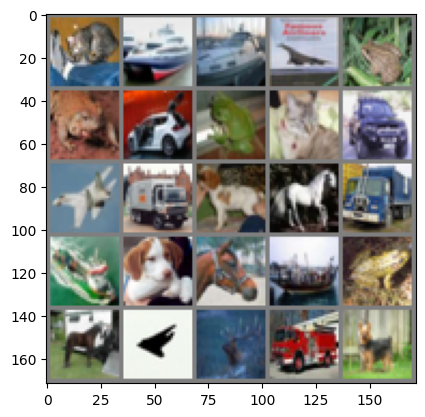

GroundTruth: 
cat   ship  ship  plane frog 
frog  car   frog  cat   car  
plane truck dog   horse truck
ship  dog   horse ship  frog 
horse plane deer  truck dog  

Predicted:   
cat   car   plane ship  deer 
frog  truck frog  cat   car  
deer  truck dog   horse car  
ship  dog   cat   ship  frog 
horse plane deer  truck deer 


In [82]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images, nrow=5))

# images = images.to(device)
# labels = labels.to(device)

print("GroundTruth: ")
for j in range(0, batch_size, 5):
    print(' '.join(f'{classes[labels[i]]:5s}' for i in range(j, min(j+5, batch_size))))
# print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print("\nPredicted:   ")
for j in range(0, batch_size, 5):
    print(' '.join(f'{classes[predicted[i]]:5s}' for i in range(j, min(j+5, batch_size))))
# print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

In [83]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct // total
print(f'Accuracy of the CNN on the test images: {accuracy} %')
# print(f'Accuracy of the VGG16 on the 10000 test images: {accuracy} %')

Accuracy of the CNN on the test images: 64 %


In [84]:
# 用于计算每个class的准确率
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 输出每个class的准确率
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 71.3 %
Accuracy for class: car   is 72.8 %
Accuracy for class: bird  is 54.4 %
Accuracy for class: cat   is 49.9 %
Accuracy for class: deer  is 56.9 %
Accuracy for class: dog   is 48.9 %
Accuracy for class: frog  is 71.8 %
Accuracy for class: horse is 70.3 %
Accuracy for class: ship  is 75.4 %
Accuracy for class: truck is 72.3 %


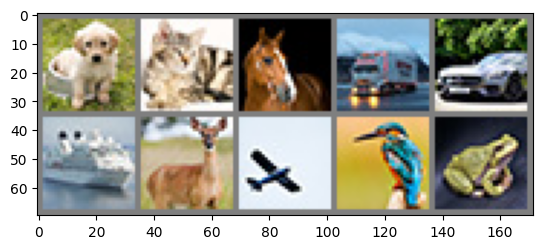

True Labels: 
dog   cat   horse truck car   ship  deer  plane bird  frog 

Predicted:   
dog   frog  dog   plane car   ship  deer  plane bird  frog 


In [85]:
# 测试自己的数据
from PIL import Image
import os
import re
from torch.utils.data import TensorDataset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

my_images = []
true_labels = []

# 获取my_data文件夹中的数据
folder_path = './my_data/'
files = os.listdir(folder_path)
for file in files:
    file_path = os.path.join(folder_path, file)  # 获取文件的完整路径
    # 通过Image获取处理图像
    img = Image.open(file_path).convert('RGB')
    img = transform(img)
    my_images.append(img)
    # 根据文件名获取图片标签
    name = os.path.splitext(file)[0]
    match = re.search(r'\d+', name)
    if (match):
        label = int(match.group())
        true_labels.append(label)
my_images = torch.stack(my_images)
true_labels = torch.tensor(true_labels)
# 数据集
data = TensorDataset(my_images, true_labels)
# 打乱数据集
# 生成随机排列的索引进行重排
indices = torch.randperm(len(data))
data.tensors = [tensor[indices] for tensor in data.tensors]

my_images, true_labels = data.tensors

# 展示测试集
imshow(torchvision.utils.make_grid(my_images, nrow=5))

with torch.no_grad():
    outputs = net(my_images)
    _, predicted = torch.max(outputs.data, 1)
    print("True Labels: ")
    print(' '.join(f'{classes[true_labels[i]]:5s}' for i in range(10)))
    print("\nPredicted:   ")
    print(' '.join(f'{classes[predicted[i]]:5s}' for i in range(10)))
